# Using Variational Autoencoder and Deep Feature Loss to Generate Faces

From the "Using Variational Autoencoder to Generate Faces" example, we see that using VAE, we can generate realistic human faces, but the generated image is a little blury. Though, you can continue to tuning the hyper paramters or using more data to get a better result, in this example, we adopted the approach in [this paper](https://arxiv.org/abs/1610.00291). That is, instead of using pixel-by-pixel loss of between the original images and the generated images, we use the feature map generated by a pre-trained CNN network to define a feature perceptual loss. As you will see, the generated images will become more vivid.

In [1]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.dataset import mnist
import datetime as dt
from bigdl.util.common import *
from glob import glob
import os
import scipy.misc
import numpy as np
from utils import *

image_size = 148
Z_DIM = 100
ENCODER_FILTER_NUM = 32
DATA_PATH = "/tmp/celeba/img_align_celeba"

init_engine()

## Define the Model

We are uing the same model as "Using Variational Autoencoder to Generate Faces" example.

In [2]:
def conv_bn_lrelu(in_channels, out_channles, kw=4, kh=4, sw=2, sh=2, pw=-1, ph=-1):
    model = Sequential()
    model.add(SpatialConvolution(in_channels, out_channles, kw, kh, sw, sh, pw, ph))
    model.add(SpatialBatchNormalization(out_channles))
    model.add(LeakyReLU(0.2))
    return model

def deconv_bn_lrelu(in_channels, out_channles, kw=4, kh=4, sw=2, sh=2, pw=0, ph=0):
    model = Sequential()
    model.add(SpatialFullConvolution(in_channels, out_channles, kw, kh, sw, sh, pw, ph))
    model.add(SpatialBatchNormalization(out_channles))
    model.add(LeakyReLU(0.2))
    return model

In [3]:
def get_encoder_cnn():
    model = Sequential()
    
    #CONV
    model.add(conv_bn_lrelu(3, 32)) # 32 * 32 * 32
    model.add(conv_bn_lrelu(32, 64)) # 16 * 16 * 64
    model.add(conv_bn_lrelu(64, 128)) # 8 * 8 * 128
    model.add(conv_bn_lrelu(128, 256)) # 4 * 4 * 256
    model.add(View([4*4*256]))
    
    # FULLYCONNECTED
    concat = ConcatTable()
    concat.add(Linear(4*4*256, Z_DIM))
    concat.add(Linear(4*4*256, Z_DIM))
    
    model.add(Reshape([4*4*256]))
    model.add(concat)
    return model

In [4]:
def get_decoder_cnn():
    model = Sequential()
    model.add(Linear(Z_DIM, 4*4*256))
    model.add(Reshape([256, 4, 4]))
    model.add(SpatialBatchNormalization(256))
    
    model.add(deconv_bn_lrelu(256, 128, pw=1, ph=1)) # 8 * 8 * 128
    model.add(deconv_bn_lrelu(128, 64, pw=1, ph=1)) # 16 * 16 * 64
    model.add(deconv_bn_lrelu(64, 32, pw=1, ph=1)) # 32 * 32 * 32
    model.add(deconv_bn_lrelu(32, 3, pw=1, ph=1)) # 64 * 64 * 3
    model.add(Tanh())
    return model

In [5]:
def get_autoencoder_cnn():
    encoder = get_encoder_cnn()
    decode = get_decoder_cnn()
    
    decoder = Sequential()
    decoder.add(GaussianSampler())
    decoder.add(decode)
    
    concat = ConcatTable()
    concat.add(Identity())
    concat.add(decoder)
    
    model = Sequential()
    model.add(encoder)
    model.add(concat)
    return model, decode

## Load the pre-trained CNN model

In [6]:
def get_vgg():
    # we use the vgg16 model, it should work on other popular CNN models
    # You can download them here (link TO BE ADDED)
    vgg_whole = Model.from_jvalue(Model.loadModel("/tmp/bigdl/vgg16.bigdl").value)

    # we only use one feature map here for the sake of simlicity and efficiency
    outputs = [vgg_whole.node(name) for name in ["relu1_2"]]
    inputs = [vgg_whole.node(name) for name in ["data"]]

    vgg_light = Model(inputs, outputs).freeze()
    
    return vgg_light
    

In [7]:
vgg = get_vgg()

creating: createModel
creating: createParallelTable
creating: createInferReshape
creating: createInferReshape
creating: createSequential


In [8]:
model, decoder = get_autoencoder_cnn()

creating: createSequential
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createView
creating: createConcatTable
creating: createLinear
creating: createLinear
creating: createReshape
creating: createSequential
creating: createLinear
creating: createReshape
creating: createSpatialBatchNormalization
creating: createSequential
creating: createSpatialFullConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialFullConvolution
creating: createSp

## Load the Datasets

In [12]:
def get_data():
    data_files = glob(os.path.join(DATA_PATH, "*.jpg"))
    
    rdd_train_images = sc.parallelize(data_files[:100000]) \
                              .map(lambda path: get_image(path, image_size).transpose(2, 0, 1))

    rdd_train_sample = rdd_train_images.map(lambda img: Sample.from_ndarray(img, [np.array(0.0), img]))
    return rdd_train_sample

In [13]:
train_data = get_data()

## Define the Training Objective

In [15]:
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 0.004)
criterion.add(TransformerCriterion(MSECriterion(), vgg, vgg), 1.0)

creating: createParallelCriterion
creating: createKLDCriterion
creating: createMSECriterion
creating: createTransformerCriterion


## Define the Optimizer

In [16]:
batch_size = 100


# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=criterion,
    optim_method=Adam(0.0005),
    end_trigger=MaxEpoch(10),
    batch_size=batch_size)


app_name='vae-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/vae',
                                     app_name=app_name)


optimizer.set_train_summary(train_summary)

print "saving logs to ",app_name

creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createTrainSummary
saving logs to  vae-20171222-125559


## Spin Up the Training

In [17]:
redire_spark_logs()
show_bigdl_info_logs()
trained_model = optimizer.optimize()

In [18]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


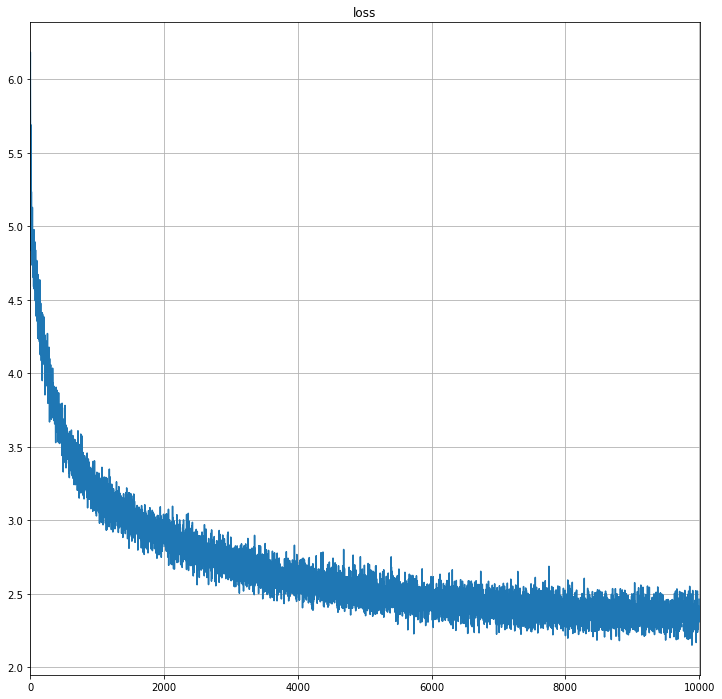

In [19]:
loss = np.array(train_summary.read_scalar("Loss"))

plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

## Random Sample Some Images

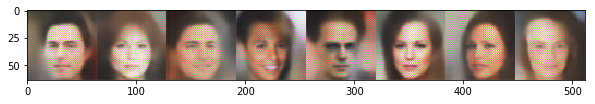

In [20]:
from matplotlib.pyplot import imshow
plt.figure(figsize=(10, 80))
img = np.column_stack([decoder.forward(np.random.randn(1, 100)).reshape(3, 64,64).transpose(1, 2, 0) for s in range(8)])
imshow(inverse_transform(img))